In [2]:
from __future__ import print_function, division

import numpy as np
import scipy as sp
import neurofit as nf
import utils as utils

import statsmodels.api as sm
import sklearn.linear_model as lm

import scipy.stats as ss

from os import walk

import glm
import pyspike as pyspk

#plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package

from glm import GLM_cos

sns.set_style("whitegrid")

In [4]:
# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

# glmsettings
nwalkers = 1000
burn = 500
dstrf_burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
nbatch = 15
free_ts = True

nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
hlen = int(np.rint(75/t_dsample))
psth_smooth = 5/t_dsample

compress = 1

nonlin = False

channels = 1
scale = 1

# setup cosine basis
ntcos = 10
nhcos = 5

tbas, fromt, tot = utils.cosbasis(tlen,ntcos,lin=100,retfn=True)
hbas, fromh, toh = utils.cosbasis(hlen,nhcos,lin=10,retfn=True)


# load data from crcns
spikesroot = "/home/data/crcns/all_cells/" + cell + "/" + stim_type +"/"
stimroot = "/home/data/crcns/all_stims/"

spikefiles = [f for f in next(walk(spikesroot))[2] if len(f.split(".")) == 2]
stimfiles = [f.split(".")[0] + ".wav" for f in spikefiles]

stims,durations = utils.load_sound_data(stimfiles, stimroot, dsample=t_dsample,sres=nspec,gammatone=True,compress=compress)
spikes_data, spiky_data = utils.load_spikes_data(spikefiles, spikesroot, durations)
psth_data = [utils.psth_spiky(spiky,binres=1,smooth=psth_smooth,dsample=t_dsample) for spiky in spiky_data]
norm_psth_data = [nf.utils.normalize(p,center=False) for p in psth_data]
psth_iapp = [resample(nf.utils.normalize(x),durations[i])*scale for i,x in enumerate(psth_data)]
norm_psth_data = [nf.utils.normalize(p) for p in psth_data]
dsdur = np.asarray(durations)/t_dsample

/scratch/tyler/dstrf/.pip/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


NameError: name 'resample' is not defined

In [173]:
STRF_GUESS, B_GUESS = utils.get_strf(stims,fit_psth,nkt)
SPEC,TIM = utils.factorize(STRF_GUESS,1)
start = np.hstack(([[B_GUESS]],SPEC,tot(TIM),[[0]*5])).flatten()

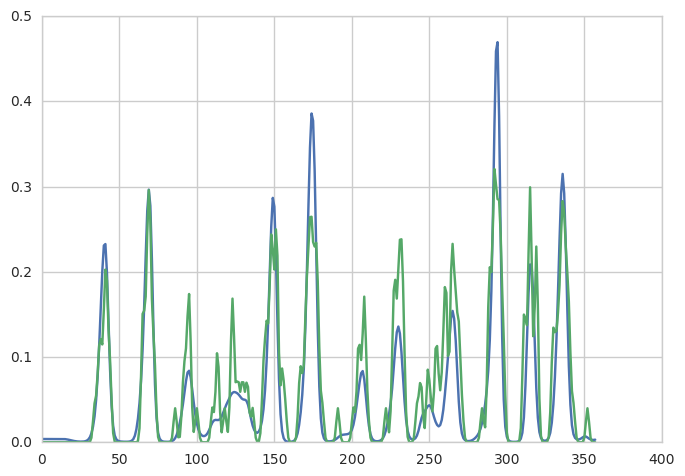

In [394]:
model = GLM_design(1,nkx,nkt,nh,hcos=5,tcoslin=100,nonlin=np.exp,spike=True,dt=dt)
model.set(start)
plot(model.run([XXstim[0],[XXspk[0][0]]])[0][0].T)
plot(all_psth[0])

In [416]:
def loss(predict,data):
    #print(np.sum(1000*((predict - data))**2)/len(predict))
    return np.sum(1000*((predict - data))**2)/len(predict)

def loss2(predict,data):
    #print(-np.sum(ss.norm.logpdf(predict,loc=data)))
    return -np.sum(ss.norm.logpdf(predict,loc=data))

def pploss(predict,data):
    lam,spikes = predict
    #if np.shape(lam[0]) == ():
    #    lam = [lam]
    #    spikes = [spikes]
    return -np.sum([np.sum(np.log(l[s])) - np.sum(l) for s,l in zip(spikes,lam)])

def pploss2(predict,data):
    lam,spikes = predict
    mask = np.zeros(len(lam),bool)
    mask[spikes] = True
    sterm = np.sum(np.log(lam[mask])) if len(spikes) > 0 else 0
    nterm = np.sum(np.log(1-lam[~mask])) 
    #print(sterm+nterm,sterm,nterm,lam[~mask])
    return -sterm + nterm 

def cost(theta, model, lnprior, lnlike, observs,fixed):

    lp = lnprior(theta)
    if not np.isfinite(lp): return -np.inf
    params = np.hstack((fixed,theta))
    
    model.set(params)
    
    ll = 0
    for stim, data, in observs:
        ll += lnlike(model.run(stim), data)
        if np.isnan(ll): return -np.inf
        
    return -ll + lp
                 
prior = nf.priors.unbounded()

In [418]:
import glm
model = glm.GLM_cos(1,nkx,nkt,nh,hcos=5,tcoslin=100,nonlin=np.exp,spike=True,dt=dt)

data = zip(zip(stims,all_spikes),all_psth)

ncost = lambda *args: -cost(*args)

from scipy import optimize as opt

fixed = start[:-5]
%time result = opt.minimize(ncost,start[-5:],args=(model,prior,pploss,data,fixed))

CPU times: user 5.46 s, sys: 0 ns, total: 5.46 s
Wall time: 5.96 s


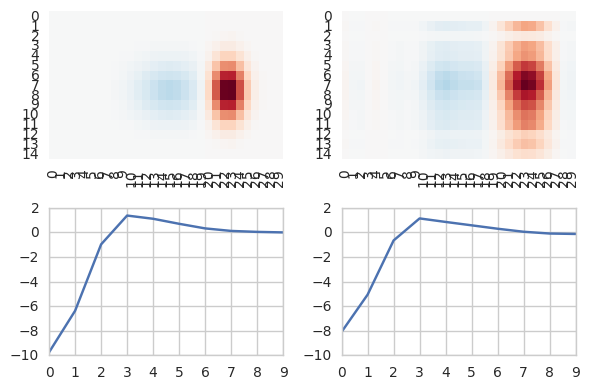

In [23]:
emcee_start = np.hstack((fixed,result['x']))
model.set(emcee_start)

subplot(221)
sns.heatmap(k,cbar=False)

subplot(222)
sns.heatmap(model.k.filt,cbar=False)

subplot(223)
plot(h)

subplot(224)
plot(model.h.filt.T)

tight_layout()

In [24]:
import emcee

nwalkers = 1000
pos0 = emcee.utils.sample_ball(start,[0.1]*len(start),nwalkers)

out = nf.fit(all_psth,zip(stims,all_spikes),model,prior,pploss,nwalkers,1000,1,pos0,progress_bar=True,threads=8)

glm.py:122: RuntimeWarning: overflow encountered in exp
  rate.append(self.nonlin(synap + post + self.offset)*self.dt)
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


 [          ] 1/1000 samples in 00:11 about 18:55 remaining

glm.py:122: RuntimeWarning: overflow encountered in exp
  rate.append(self.nonlin(synap + post + self.offset)*self.dt)
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


 [          ] 2/1000 samples in 00:17 about 40:40 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 3/1000 samples in 00:23 about 38:49 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 4/1000 samples in 00:29 about 36:59 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 6/1000 samples in 00:41 about 35:30 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 7/1000 samples in 00:47 about 34:18 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 13/1000 samples in 01:22 about 35:20 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 14/1000 samples in 01:28 about 41:08 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 27/1000 samples in 02:44 about 37:24 remaining

KeyboardInterrupt: 

In [25]:
model.set(out.flatchain[np.argmax(out.flatlnprobability)])
subplot(211)
sns.heatmap(model.k.filt,cbar=False)

subplot(212)
plot(model.h.filt.T)

NameError: name 'out' is not defined

In [ ]:
plot(all_r[0][0])
plot(model.run([stims[0],all_spikes[0][0]])[0])